In [1]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Saving the data into memory for faster training
!unzip "/content/drive/MyDrive/MASTER_THESIS/Models/Dataset/Dataset.zip" -d "/content"

In [3]:
# Checking GPU
!nvidia-smi

Wed Nov 30 15:32:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np 
import os

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms as T 
from torchvision.models import vgg16, VGG16_Weights
from torchsummary import summary


import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sn 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
 
from tqdm import tqdm 
import time 
import copy
import warnings 
warnings.filterwarnings("ignore")

In [5]:
# Extracting all classes in the dataset
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [6]:
# Load and transform data
def get_data_loaders(data_dir, batch_size, train = False):
    if train: # Training data
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            T.RandomErasing(p=0.25, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)

    else: # Validation and test data
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [7]:
dataset_path = "/content/Dataset"

In [8]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [9]:
classes = get_classes("/content/Dataset/train")
print(classes, len(classes))

['MildDemented', 'ModerateDemented', 'NonDemented'] 3


In [10]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [11]:
print(len(train_loader), len(val_loader), len(test_loader))

91 20 20


In [12]:
print(train_data_len, valid_data_len, test_data_len)

2911 623 626


In [13]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
# Create model
weights = VGG16_Weights.IMAGENET1K_V1
model = torchvision.models.vgg16(weights = weights, progress = True)

In [22]:
# Freezing model
for param in model.parameters():
    param.requires_grad = False

# Unfreezing the last 2 convolutional layers
for param in model.features[-6:].parameters():
    param.requires_grad = True

# Changing the classification head
n_inputs = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(classes)),
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=25088, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=256, out_features=3, bias=True)
)


In [23]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [24]:
# Setting Hyperparameters
epochs = 50
weights = [3.5, 51, 1]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)
criterion = criterion.to(device)

optimizer = optim.RMSprop(model.classifier.parameters(), lr=0.0001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [25]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [26]:
# Train model
model = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/49
----------


100%|██████████| 91/91 [00:15<00:00,  5.71it/s]


train Loss: 1.4702 Acc: 0.5665


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


val Loss: 0.7353 Acc: 0.7143

Epoch 1/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.48it/s]


train Loss: 0.9338 Acc: 0.6627


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


val Loss: 0.7121 Acc: 0.6982

Epoch 2/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.30it/s]


train Loss: 0.7441 Acc: 0.6980


100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


val Loss: 0.5337 Acc: 0.7673

Epoch 3/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.16it/s]


train Loss: 0.7213 Acc: 0.7108


100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


val Loss: 0.4787 Acc: 0.8154

Epoch 4/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.27it/s]


train Loss: 0.6695 Acc: 0.7369


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


val Loss: 0.5362 Acc: 0.7705

Epoch 5/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.25it/s]


train Loss: 0.6508 Acc: 0.7406


100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


val Loss: 0.5083 Acc: 0.7753

Epoch 6/49
----------


100%|██████████| 91/91 [00:18<00:00,  4.82it/s]


train Loss: 0.5943 Acc: 0.7695


100%|██████████| 20/20 [00:04<00:00,  4.78it/s]


val Loss: 0.4416 Acc: 0.8218

Epoch 7/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.11it/s]


train Loss: 0.5652 Acc: 0.7801


100%|██████████| 20/20 [00:04<00:00,  4.60it/s]


val Loss: 0.4901 Acc: 0.7913

Epoch 8/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.26it/s]


train Loss: 0.4703 Acc: 0.7929


100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


val Loss: 0.3895 Acc: 0.8218

Epoch 9/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.34it/s]


train Loss: 0.4539 Acc: 0.7929


100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


val Loss: 0.4611 Acc: 0.7945

Epoch 10/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.10it/s]


train Loss: 0.4524 Acc: 0.7997


100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


val Loss: 0.3680 Acc: 0.8411

Epoch 11/49
----------


100%|██████████| 91/91 [00:18<00:00,  5.03it/s]


train Loss: 0.4702 Acc: 0.8021


100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


val Loss: 0.3593 Acc: 0.8459

Epoch 12/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.26it/s]


train Loss: 0.4335 Acc: 0.8052


100%|██████████| 20/20 [00:04<00:00,  4.74it/s]


val Loss: 0.3207 Acc: 0.8539

Epoch 13/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.06it/s]


train Loss: 0.3945 Acc: 0.8148


100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


val Loss: 0.3923 Acc: 0.8347

Epoch 14/49
----------


100%|██████████| 91/91 [00:18<00:00,  5.00it/s]


train Loss: 0.4105 Acc: 0.8193


100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


val Loss: 0.3124 Acc: 0.8700

Epoch 15/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.38it/s]


train Loss: 0.3878 Acc: 0.8265


100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


val Loss: 0.3122 Acc: 0.8684

Epoch 16/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.25it/s]


train Loss: 0.3926 Acc: 0.8203


100%|██████████| 20/20 [00:04<00:00,  4.58it/s]


val Loss: 0.3234 Acc: 0.8604

Epoch 17/49
----------


100%|██████████| 91/91 [00:18<00:00,  5.02it/s]


train Loss: 0.3967 Acc: 0.8313


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


val Loss: 0.2942 Acc: 0.8684

Epoch 18/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.14it/s]


train Loss: 0.4073 Acc: 0.8306


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


val Loss: 0.3143 Acc: 0.8700

Epoch 19/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.16it/s]


train Loss: 0.3635 Acc: 0.8444


100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


val Loss: 0.3251 Acc: 0.8587

Epoch 20/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.07it/s]


train Loss: 0.3766 Acc: 0.8392


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


val Loss: 0.3145 Acc: 0.8716

Epoch 21/49
----------


100%|██████████| 91/91 [00:18<00:00,  4.95it/s]


train Loss: 0.3331 Acc: 0.8437


100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


val Loss: 0.2773 Acc: 0.8780

Epoch 22/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.35it/s]


train Loss: 0.3113 Acc: 0.8509


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


val Loss: 0.3296 Acc: 0.8652

Epoch 23/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.39it/s]


train Loss: 0.2964 Acc: 0.8537


100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


val Loss: 0.3017 Acc: 0.8716

Epoch 24/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.18it/s]


train Loss: 0.3064 Acc: 0.8537


100%|██████████| 20/20 [00:04<00:00,  4.74it/s]


val Loss: 0.2917 Acc: 0.8716

Epoch 25/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.27it/s]


train Loss: 0.3778 Acc: 0.8612


100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


val Loss: 0.2910 Acc: 0.8780

Epoch 26/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.55it/s]


train Loss: 0.2787 Acc: 0.8667


100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


val Loss: 0.2721 Acc: 0.8876

Epoch 27/49
----------


100%|██████████| 91/91 [00:18<00:00,  4.91it/s]


train Loss: 0.3017 Acc: 0.8715


100%|██████████| 20/20 [00:04<00:00,  4.76it/s]


val Loss: 0.3505 Acc: 0.8523

Epoch 28/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.48it/s]


train Loss: 0.2851 Acc: 0.8681


100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


val Loss: 0.2550 Acc: 0.8844

Epoch 29/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.43it/s]


train Loss: 0.2956 Acc: 0.8684


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


val Loss: 0.2763 Acc: 0.8764

Epoch 30/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.12it/s]


train Loss: 0.2810 Acc: 0.8681


100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


val Loss: 0.3037 Acc: 0.8700

Epoch 31/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.17it/s]


train Loss: 0.2229 Acc: 0.8866


100%|██████████| 20/20 [00:04<00:00,  4.60it/s]


val Loss: 0.2674 Acc: 0.8909

Epoch 32/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.22it/s]


train Loss: 0.2438 Acc: 0.8739


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


val Loss: 0.2454 Acc: 0.9021

Epoch 33/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.35it/s]


train Loss: 0.2968 Acc: 0.8829


100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


val Loss: 0.2551 Acc: 0.9005

Epoch 34/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.56it/s]


train Loss: 0.2459 Acc: 0.8726


100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


val Loss: 0.2549 Acc: 0.9021

Epoch 35/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.39it/s]


train Loss: 0.2543 Acc: 0.8846


100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


val Loss: 0.2460 Acc: 0.8989

Epoch 36/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.28it/s]


train Loss: 0.2577 Acc: 0.8818


100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


val Loss: 0.2792 Acc: 0.8909

Epoch 37/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.45it/s]


train Loss: 0.2778 Acc: 0.8877


100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


val Loss: 0.3207 Acc: 0.8684

Epoch 38/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.35it/s]


train Loss: 0.1968 Acc: 0.9059


100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


val Loss: 0.2626 Acc: 0.8957

Epoch 39/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.26it/s]


train Loss: 0.2239 Acc: 0.8904


100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


val Loss: 0.2530 Acc: 0.9005

Epoch 40/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.49it/s]


train Loss: 0.2287 Acc: 0.8987


100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


val Loss: 0.2323 Acc: 0.9053

Epoch 41/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.33it/s]


train Loss: 0.2740 Acc: 0.9007


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


val Loss: 0.2489 Acc: 0.9037

Epoch 42/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.39it/s]


train Loss: 0.1941 Acc: 0.9103


100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


val Loss: 0.2439 Acc: 0.9053

Epoch 43/49
----------


100%|██████████| 91/91 [00:17<00:00,  5.32it/s]


train Loss: 0.1995 Acc: 0.9045


100%|██████████| 20/20 [00:04<00:00,  4.78it/s]


val Loss: 0.2295 Acc: 0.9149

Epoch 44/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.49it/s]


train Loss: 0.2617 Acc: 0.9055


100%|██████████| 20/20 [00:04<00:00,  4.62it/s]


val Loss: 0.3141 Acc: 0.8716

Epoch 45/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.44it/s]


train Loss: 0.2086 Acc: 0.9107


100%|██████████| 20/20 [00:04<00:00,  4.79it/s]


val Loss: 0.2558 Acc: 0.9021

Epoch 46/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.45it/s]


train Loss: 0.2333 Acc: 0.9028


100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


val Loss: 0.2192 Acc: 0.9133

Epoch 47/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.47it/s]


train Loss: 0.2006 Acc: 0.9134


100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


val Loss: 0.2149 Acc: 0.9197

Epoch 48/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.54it/s]


train Loss: 0.2220 Acc: 0.9121


100%|██████████| 20/20 [00:04<00:00,  4.35it/s]


val Loss: 0.2346 Acc: 0.9085

Epoch 49/49
----------


100%|██████████| 91/91 [00:16<00:00,  5.43it/s]


train Loss: 0.2306 Acc: 0.9189


100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

val Loss: 0.2605 Acc: 0.9005

Training complete in 18m 3s
Best Val Acc: 0.9197


In [27]:
# Create true and predicted labels for the test data

y_pred = []
y_true = []

since = time.time()

for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

time_elapsed = time.time() - since
print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


Testing complete in 0m 5s


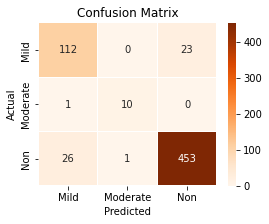

In [38]:
label_name = ['Mild', 'Moderate', 'Non']

# Build confusion matrix
cm = confusion_matrix(y_true,y_pred)
f, ax = plt.subplots(figsize=(4,3))
sn.heatmap(cm,  annot=True, fmt="d" ,cmap="Oranges", linewidths=0.01, xticklabels=label_name, yticklabels=label_name)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [34]:
print(classification_report(y_true, y_pred, target_names=label_name, digits = 4))

              precision    recall  f1-score   support

        Mild     0.8058    0.8296    0.8175       135
    Moderate     0.9091    0.9091    0.9091        11
         Non     0.9517    0.9437    0.9477       480

    accuracy                         0.9185       626
   macro avg     0.8888    0.8942    0.8914       626
weighted avg     0.9195    0.9185    0.9189       626



In [39]:
# Save model
torch.save(model, "VGG16_92%.pt" )